# Steering Analysis

Analysis of steering results, plotting log probability trajectories by role and steering magnitude.

In [1]:
import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Configuration
DATA_PATH = '../data/Qwen3-30B-A3B-Instruct-2507/role_responses/avg_response_sys_diff.csv'
LOGPROBS_SYS_PATH = '../../logits/data/Qwen3-30B-A3B-Instruct-2507/logprobs_with_sys.csv'
LOGPROBS_NO_SYS_PATH = '../../logits/data/Qwen3-30B-A3B-Instruct-2507/logprobs_no_sys.csv'
OUTPUT_DIR = 'plots'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load Data
df = pd.read_csv(DATA_PATH)
print(f"Loaded steering data shape: {df.shape}")

# Load unsteered logprobs data
df_logits_sys = pd.read_csv(LOGPROBS_SYS_PATH)
df_logits_no_sys = pd.read_csv(LOGPROBS_NO_SYS_PATH)
print(f"Loaded unsteered sys logprobs shape: {df_logits_sys.shape}")
print(f"Loaded unsteered no-sys logprobs shape: {df_logits_no_sys.shape}")

# Parse logprobs
def parse_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df['first_100_response_log_probs'] = df['first_100_response_log_probs'].apply(parse_list)
df_logits_sys['first_100_response_log_probs'] = df_logits_sys['first_100_response_log_probs'].apply(parse_list)
df_logits_no_sys['first_100_response_log_probs'] = df_logits_no_sys['first_100_response_log_probs'].apply(parse_list)
print("Parsed logprobs columns.")

Loaded steering data shape: (1200, 10)
Loaded unsteered sys logprobs shape: (6300, 8)
Loaded unsteered no-sys logprobs shape: (6300, 8)
Parsed logprobs columns.


In [3]:
def get_avg_trajectory(series_of_lists):
    # Find max length
    if len(series_of_lists) == 0:
        return np.array([])

    # Create a matrix
    # We assume max length 100 based on column name, but let's be safe
    matrix = np.full((len(series_of_lists), 100), np.nan)
    for i, lst in enumerate(series_of_lists):
        if isinstance(lst, list) and len(lst) > 0:
            length = min(len(lst), 100)
            matrix[i, :length] = lst[:length]

    return np.nanmean(matrix, axis=0)

# Get unique roles
roles = df['role_name'].unique()
print(f"Found {len(roles)} unique roles.")

Found 6 unique roles.


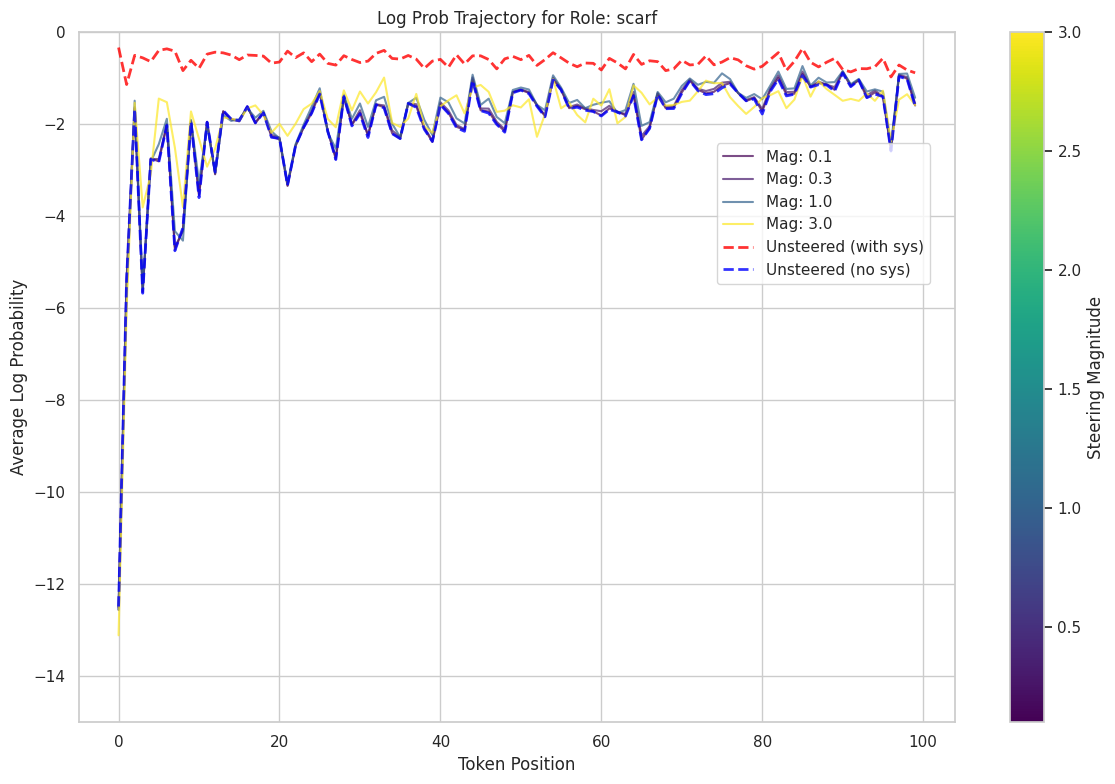

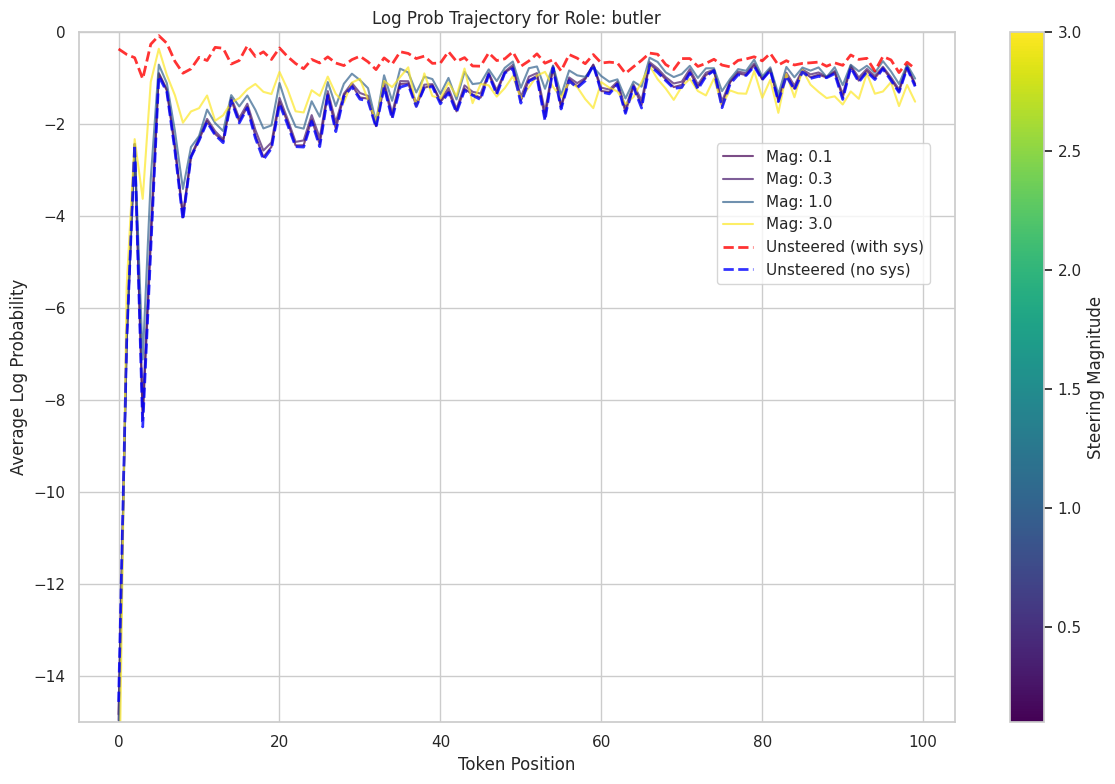

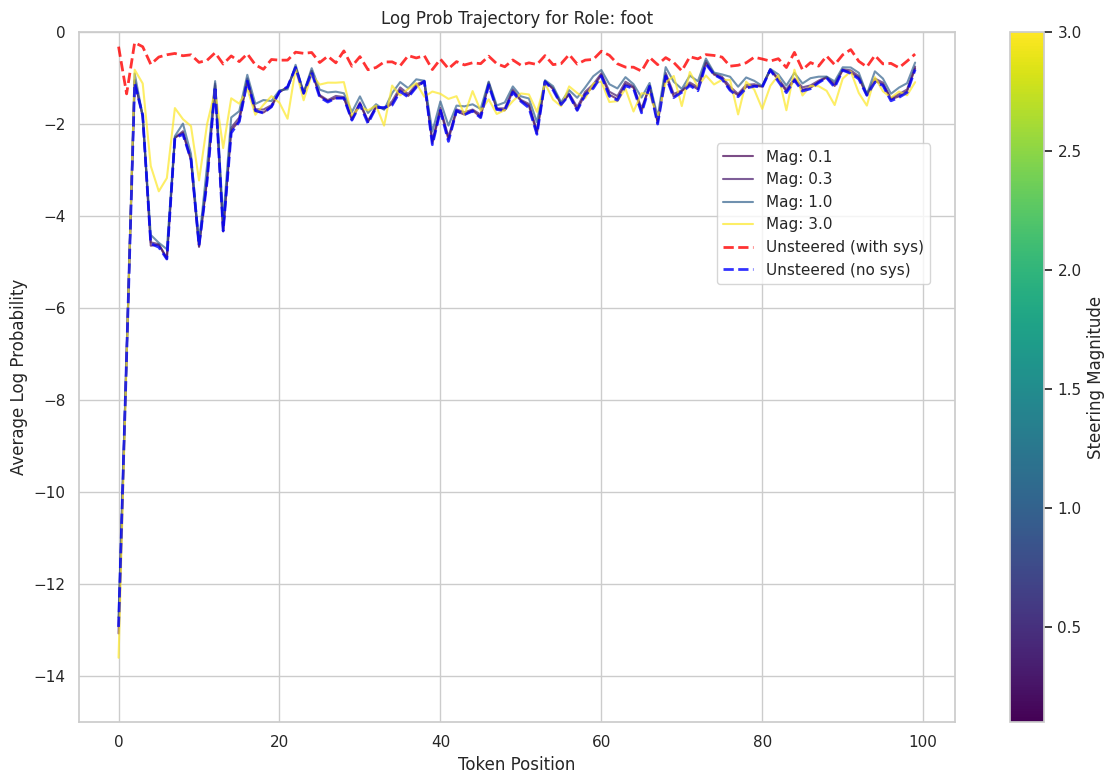

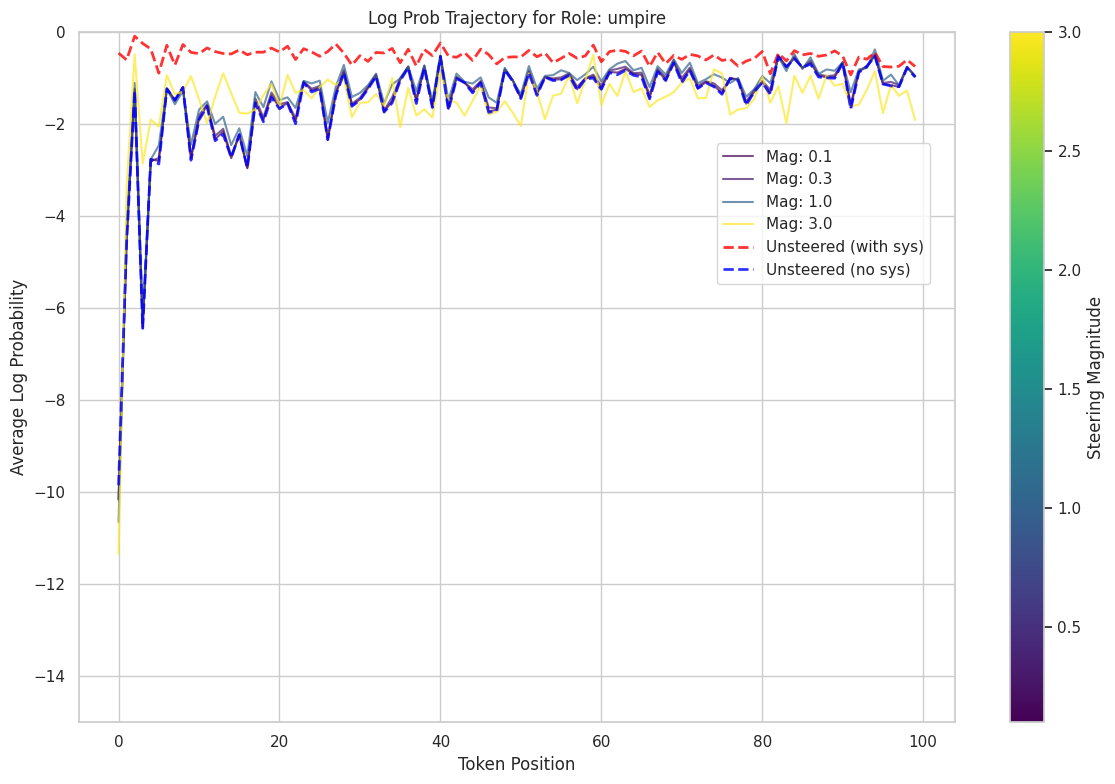

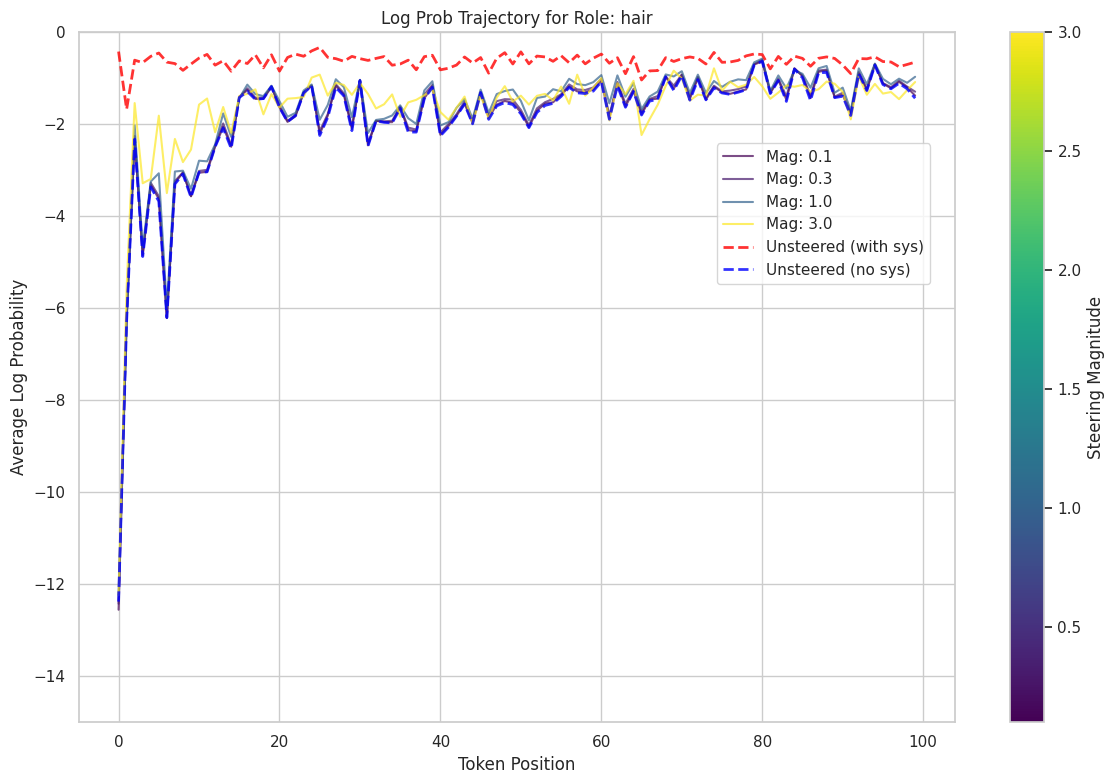

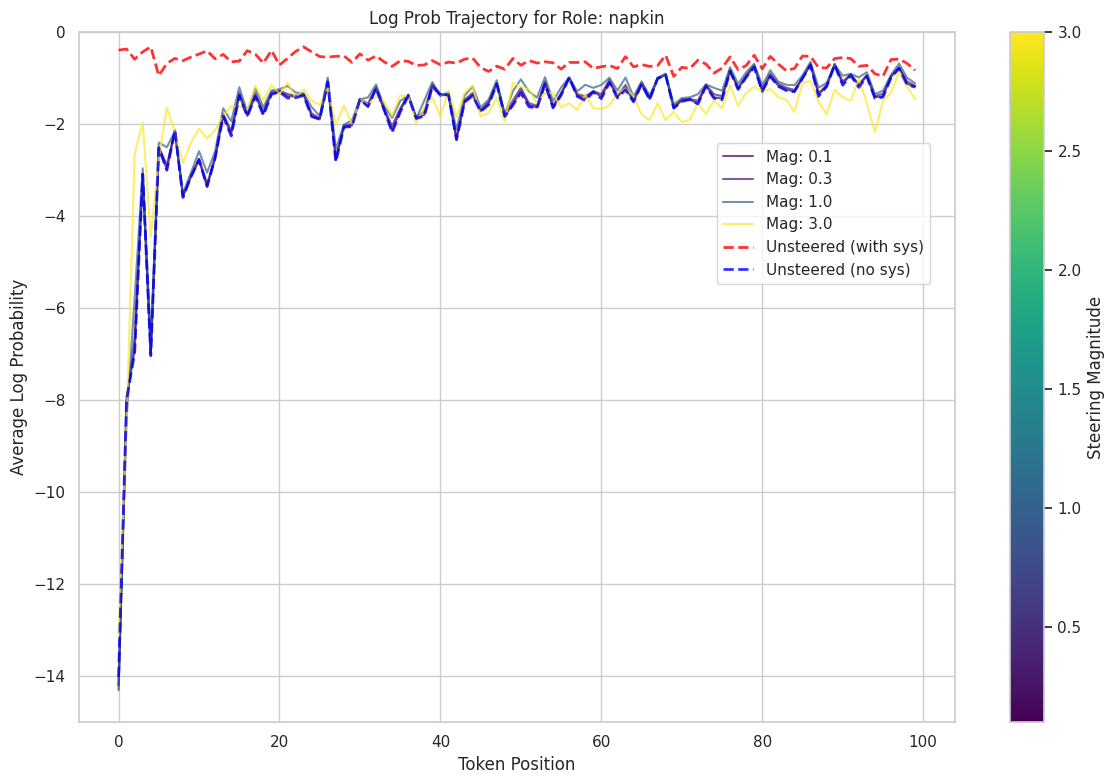

In [5]:
# Plotting Loop
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for role in roles:
    role_df = df[df['role_name'] == role]

    # Get unique magnitudes and sort them
    magnitudes = sorted(role_df['steering_magnitude'].unique())

    if len(magnitudes) == 0:
        continue

    fig, ax = plt.subplots(figsize=(12, 8))

    # Setup colormap
    # Normalize magnitudes to 0-1 for colormap
    norm = mcolors.Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
    cmap = cm.viridis

    # Plot steering trajectories
    for mag in magnitudes:
        mag_df = role_df[role_df['steering_magnitude'] == mag]
        avg_traj = get_avg_trajectory(mag_df['first_100_response_log_probs'])

        if len(avg_traj) > 0:
            color = cmap(norm(mag))
            ax.plot(avg_traj, color=color, label=f'Mag: {mag}', alpha=0.7)

    # Add unsteered anchor points
    role_logits_sys = df_logits_sys[df_logits_sys['role_name'] == role]
    role_logits_no_sys = df_logits_no_sys[df_logits_no_sys['role_name'] == role]
    
    if len(role_logits_sys) > 0:
        anchor_sys = get_avg_trajectory(role_logits_sys['first_100_response_log_probs'])
        if len(anchor_sys) > 0:
            ax.plot(anchor_sys, color='red', linestyle='--', linewidth=2, label='Unsteered (with sys)', alpha=0.8)
    
    if len(role_logits_no_sys) > 0:
        anchor_no_sys = get_avg_trajectory(role_logits_no_sys['first_100_response_log_probs'])
        if len(anchor_no_sys) > 0:
            ax.plot(anchor_no_sys, color='blue', linestyle='--', linewidth=2, label='Unsteered (no sys)', alpha=0.8)

    ax.set_title(f'Log Prob Trajectory for Role: {role}')
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Average Log Probability')
    ax.set_ylim(-15, 0) # Consistent y-axis as per logits_results.ipynb

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Steering Magnitude')

    # Add legend for anchor points (placed below colorbar)
    ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.85))

    plt.tight_layout()